# Install Packages and Import Modules

### Colab Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
model_path = '/content/drive/MyDrive/DS_266_Final_Project_PBI/DNABERT-2/DNABERT-2-117M'

Mounted at /content/drive


 **Note: Must run training on A100.  If you use T4 or L4, they have similar but different low level issues running this combination of triton (2.0.0.dev20221202), pytorch (1.13.1), and CUDA (12.2) while performing backprop**


 **Note: Will run inference fine on T4**

In [ ]:
# %%capture
# # Change transformers to be compatible with DNABERT-2
# !pip uninstall transformers -y  # Uninstall the current version without prompting for confirmation
# !pip install transformers==4.29.2

# # Change torch to be compatible with an older Triton version
# !pip uninstall torch -y  # Uninstall the current version without prompting for confirmation
# !pip install torch==1.13.1

# # Revert to an older triton to be compatible with DNABERT-2. Otherwise there will be significant
# # low level errors
# !pip uninstall triton -y
# !pip install triton==2.0.0.dev20221202

# # Install additional modules
# !pip install einops
# !pip install fair-esm
# !pip install h5py

In [ ]:
# Setup path for all .py files
import sys
sys.path.append('/content/drive/MyDrive/DS_266_Final_Project_PBI')

### Standard Setup

In [ ]:
import numpy as np
import pandas as pd
import pickle
import torch
from torch import nn
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
# %%capture
# !pip install optuna
# import optuna
# from optuna.visualization import plot_optimization_history, plot_param_importances

In [ ]:
# # Load files from this project
from python_files.datasets import ProteinDataset, DNADataset, CLSEmbeddingsDataset, ProteinAverageEmbeddingsDataset, ProteinMaxEmbeddingsDataset, CombinedDataset
from python_files.models import DNABertModel, CustomClassifier, ProteinOnlyClassifier
from python_files.preprocess_data import create_label_encoder
from python_files.setup import load_DNA_model
from python_files.training import create_weighted_sampler_dataloader, run_training_loop, run_inference_on_data, TrainingClass, ProteinOnlyTrainingClass, DNAOnlyTrainingClass, ProteinAndDNATrainingClass, DualHeadProteinOnlyTrainingClass
from python_files.plot_results import plot_loss_and_accuracy, plot_single_vs_dual_head
#from python_files.optuna_experiment import plot_optuna_results, save_optuna_results, print_intermediate_values

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')


# Select Working Location

### Load from Colab

In [ ]:
# File path to main folder from colab
file_path = '/content/drive/My Drive/DS_266_Final_Project_PBI/'
location = 'colab'

### Load locally

In [ ]:
# # File path to main folder locally
# file_path = '/Users/blakebleier/Library/CloudStorage/GoogleDrive-blable543@gmail.com/My Drive/DS_266_Final_Project_PBI'
# location = 'local'

# Setup Shared Parameters

In [ ]:
# All models
num_classes = 25
hidden_layer_sizes=(512,256,128,64)
keep_other=False
batch_size=32
dropout=0.3
curated=''
learning_rate = 0.0003

# Protein only
protein_combo_style='mean'
model_size = '_650M'
ESM_model_size='facebook/esm2_t33_650M_UR50D'

# Dual headed only
balance_other=True # Flag to balance data in dataloader so that "other" takes up 50% of data, and
                   # remaining classes take up the rest.  Prevents overfitting of binary classifier.

# Load the Models

## Protein Only Model

In [ ]:
# %%capture
# model_trainer = ProteinOnlyTrainingClass(file_path, device, num_classes=num_classes, protein_combo_style=protein_combo_style, hidden_layer_sizes=hidden_layer_sizes, ESM_model_size=ESM_model_size,
#                  keep_other=keep_other, model_size=model_size, dropout=dropout, batch_size=batch_size, init_mode='', curated=curated)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# model_trainer.get_data_length()

Training data is length: 3155
Validation data is length: 397


## Dual-Headed Protein Only Model

In [ ]:
# %%capture
# model_trainer = DualHeadProteinOnlyTrainingClass(file_path, device, num_classes=num_classes, protein_combo_style=protein_combo_style, hidden_layer_sizes=hidden_layer_sizes, ESM_model_size=ESM_model_size,
#                  keep_other=keep_other, model_size=model_size, dropout=dropout, batch_size=batch_size, init_mode='', curated=curated, balance_other=balance_other)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# model_trainer.get_data_length()

Training data is length: 8521
Validation data is length: 1065


## DNA Only Model

In [ ]:
# model_trainer = DNAOnlyTrainingClass(file_path, location, device, num_classes=num_classes, hidden_layer_sizes=hidden_layer_sizes, keep_other=keep_other)

## Combined Protein and DNA Model

In [ ]:
model_trainer = ProteinAndDNATrainingClass(file_path, location, device, num_classes=num_classes, protein_combo_style=protein_combo_style, hidden_layer_sizes=hidden_layer_sizes,
                 keep_other=keep_other, model_size=model_size, ESM_model_size=ESM_model_size, dropout=dropout, batch_size=batch_size)

In [ ]:
model_trainer.get_data_length()

Training data is length: 5749
Validation data is length: 730


### PCA Dimensionality Reduction

In [ ]:
model_trainer.plot_pca_analysis(figsize=(10,7))

# Train Model

## Run Inference on Normally Sampled Validation Data


In [ ]:
#accuracy, all_labels, all_predictions = model_trainer.run_inference(upsampled=False, verbose=False)
model_trainer.run_inference(upsampled=False, verbose=False)
model_trainer.confusion_matrix(figsize=(8,5))

## Run Inference on Upsampled Validation Data

In [ ]:
model_trainer.run_inference(upsampled=True, verbose=False)
model_trainer.confusion_matrix(figsize=(8,5))

## Train Model

In [ ]:
# Initialize loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_trainer.model.parameters(), lr=learning_rate)

In [ ]:
train_losses, val_losses, val_accuracies = model_trainer.run_training(loss_function=loss_function, optimizer=optimizer, num_epochs=30, validation_interval=1, plot_results=True)

In [ ]:
# Evaluation criteria
model_type = 'protein_and_dna'
single_or_double = 'single_part_2_2nd_30_epohc'
include_other = 'False'

# Set up file paths
file_name = 'optimal_loss_accuracy_results_proteinonly'
loss_accuracy_file_path = file_path + 'data/optuna_results/' + file_name + '.pkl'

# Load previous data
with open(loss_accuracy_file_path, 'rb') as f:
    loss_accuracy_df = pickle.load(f)

# Create temp df with new data
df_plots = pd.DataFrame({
        'num_hosts': num_classes,
        'hidden_layer_sizes': [hidden_layer_sizes],
        'dropout': dropout,
        'batch_size': batch_size,
        'train_losses': [train_losses],
        'validation_losses': [val_losses],
        'validation_accuracies': [val_accuracies],
        'model_type': model_type,
        'single_or_double': single_or_double,
        'include_other': include_other
    })

# Add new data to the original dataframe
loss_accuracy_df = pd.concat([loss_accuracy_df, df_plots], ignore_index=True)

# Save the results
loss_accuracy_df.to_pickle(loss_accuracy_file_path)

In [ ]:
loss_accuracy_df

In [ ]:
#accuracy, all_labels, all_predictions = model_trainer.run_inference(upsampled=False, verbose=False)
model_trainer.run_inference(upsampled=False, verbose=False)
model_trainer.confusion_matrix(figsize=(10,5))

In [ ]:
model_trainer.run_inference(upsampled=True, verbose=False)
model_trainer.confusion_matrix(figsize=(10,5))

## Confusion Matrices (5 Classes)
Run model for 30 epochs.  Run confusion matrix plot for each version.  Save results. **DO NOT DELETE**

predictions of last batch are:
tensor([[2.0341e-12, 1.4447e-04, 2.2222e-04, 7.0315e-15, 9.9963e-01],
        [9.9973e-01, 7.6520e-16, 2.7093e-04, 4.4286e-22, 4.8884e-16],
        [2.5349e-13, 2.5630e-04, 1.1052e-04, 3.4316e-14, 9.9963e-01],
        [7.3501e-23, 5.6902e-05, 1.8879e-18, 9.9994e-01, 5.8913e-19],
        [1.4327e-15, 1.1548e-04, 2.0057e-05, 1.0742e-15, 9.9986e-01],
        [9.9952e-01, 5.4869e-14, 4.8010e-04, 2.6880e-19, 3.2240e-14],
        [3.9116e-19, 1.0000e+00, 1.4618e-10, 4.3933e-06, 1.5390e-08],
        [3.3786e-03, 8.8498e-11, 9.9662e-01, 6.1686e-19, 3.5189e-09],
        [9.9940e-01, 1.3519e-13, 5.9582e-04, 1.0816e-18, 7.5528e-14],
        [3.0257e-14, 9.7766e-05, 5.4004e-05, 1.1908e-15, 9.9985e-01],
        [8.1527e-14, 1.7850e-04, 7.3375e-05, 9.3024e-15, 9.9975e-01],
        [4.3663e-13, 1.3439e-04, 1.2678e-04, 4.7108e-15, 9.9974e-01],
        [2.7320e-19, 1.0000e+00, 2.2830e-10, 1.4420e-06, 3.5080e-08]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)
------

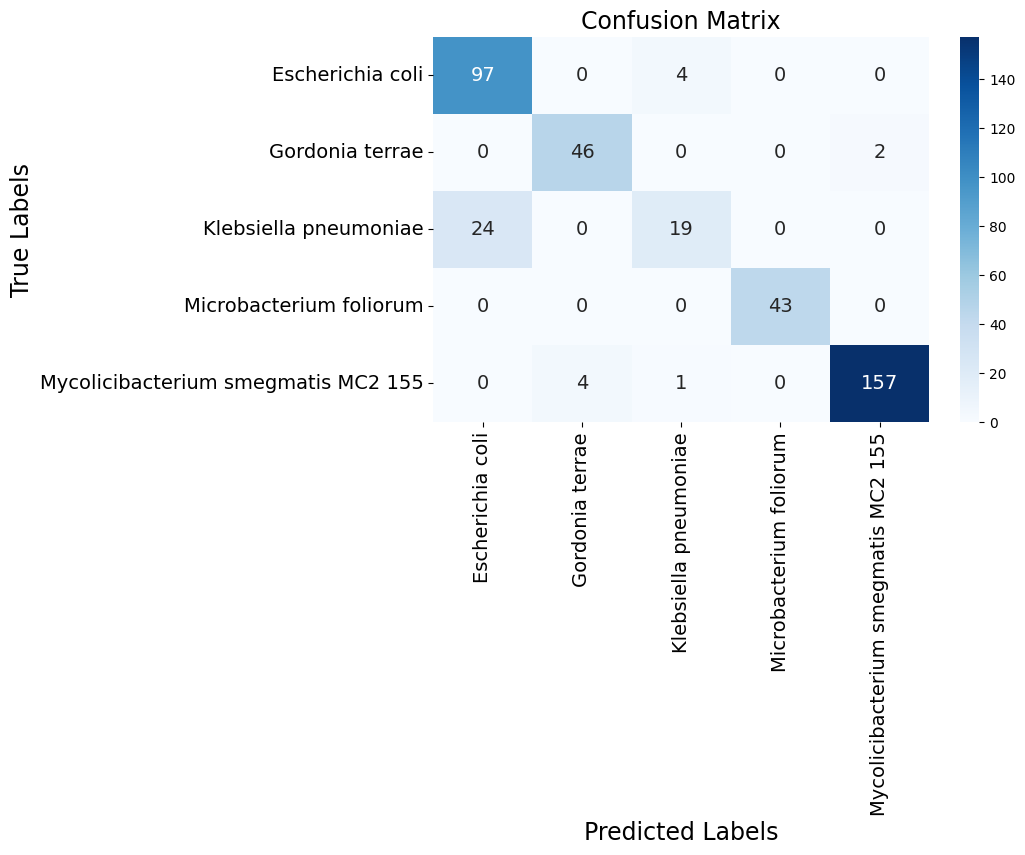

In [ ]:
# Protein only, single-headed, No Other
model_trainer.run_inference(upsampled=False, verbose=False)
model_trainer.confusion_matrix(figsize=(8,5))

predictions of last batch are:
tensor([[7.4068e-09, 3.3110e-05, 6.9610e-06, 3.3358e-15, 9.9996e-01],
        [9.9990e-01, 5.0842e-13, 1.0274e-04, 2.3130e-16, 2.1709e-11],
        [2.0963e-09, 1.0842e-04, 7.0743e-06, 3.1604e-14, 9.9988e-01],
        [1.3036e-23, 6.6556e-07, 1.0600e-14, 1.0000e+00, 1.9568e-23],
        [4.2880e-11, 2.2551e-05, 7.3018e-07, 1.2949e-16, 9.9998e-01],
        [9.9998e-01, 7.8977e-11, 2.3826e-05, 2.0210e-13, 2.1036e-09],
        [1.3286e-18, 1.0000e+00, 1.4864e-09, 2.2748e-06, 9.1470e-11],
        [9.2994e-05, 2.6149e-11, 9.9991e-01, 1.0514e-15, 4.0999e-09],
        [9.9999e-01, 4.2184e-11, 1.3579e-05, 9.7958e-14, 1.2330e-09],
        [3.3602e-10, 1.2922e-05, 1.0557e-06, 8.5089e-17, 9.9999e-01],
        [7.1597e-10, 9.1102e-05, 2.6606e-06, 1.2051e-14, 9.9991e-01],
        [1.6099e-09, 1.1931e-05, 1.6694e-06, 1.3839e-16, 9.9999e-01],
        [3.1013e-17, 1.0000e+00, 8.9592e-09, 3.3673e-07, 3.1761e-09]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)
------

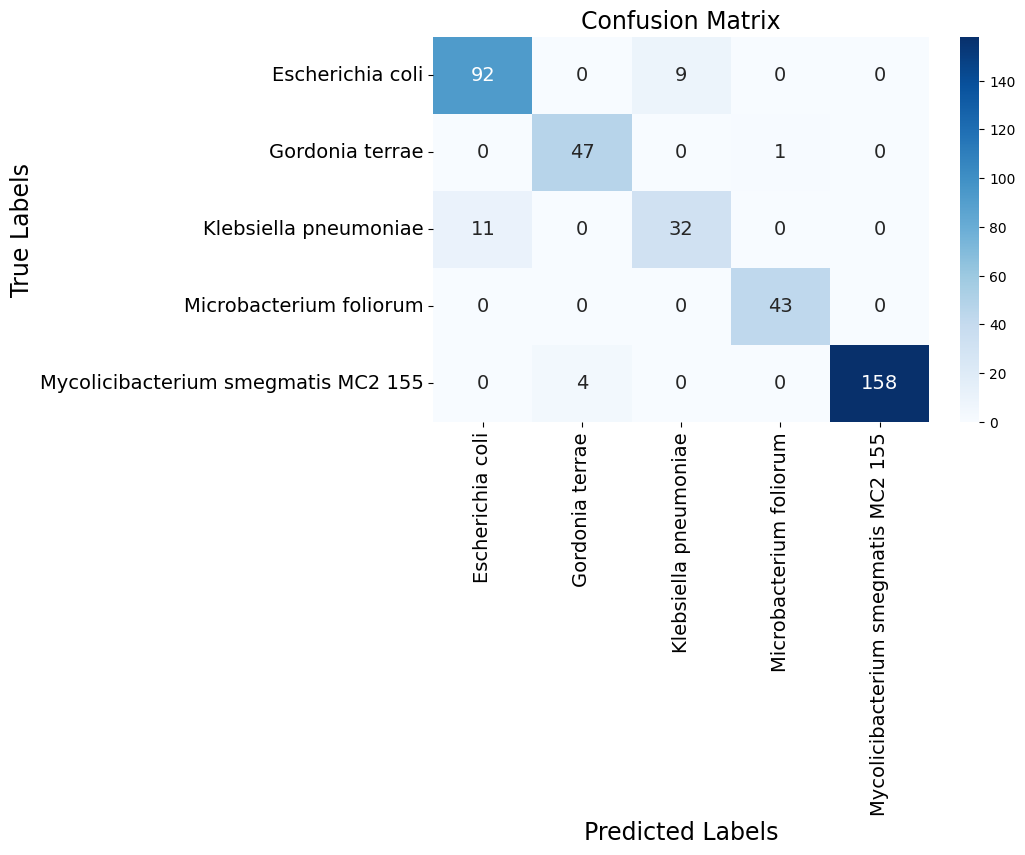

In [ ]:
# Protein and DNA, single-headed, No Other
model_trainer.run_inference(upsampled=False, verbose=False)
model_trainer.confusion_matrix(figsize=(8,5))

predictions of last batch are:
tensor([[2.2527e-05, 1.0239e-09, 5.2200e-06, 6.0343e-08, 2.7949e-14, 9.9997e-01],
        [9.9957e-01, 1.0399e-14, 3.6058e-04, 2.5341e-12, 5.2393e-14, 6.5764e-05],
        [2.8507e-30, 1.4864e-11, 6.5065e-33, 1.0000e+00, 1.9241e-36, 5.5165e-13],
        [9.2106e-11, 1.2633e-11, 4.1995e-09, 4.2677e-10, 6.0631e-20, 1.0000e+00],
        [1.6479e-15, 1.3744e-05, 3.1073e-07, 1.4764e-16, 9.9999e-01, 1.7348e-09],
        [2.7193e-14, 4.4163e-04, 1.0522e-06, 2.5610e-14, 9.9956e-01, 5.6477e-08],
        [7.0274e-17, 2.1689e-06, 6.8096e-08, 2.3066e-18, 1.0000e+00, 1.5124e-10],
        [3.8645e-03, 3.2552e-09, 9.8355e-01, 6.4099e-10, 1.3167e-08, 1.2586e-02],
        [2.7830e-20, 1.0000e+00, 8.3752e-18, 4.5992e-07, 1.6082e-15, 1.6104e-06]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)
--------------------------------------------------
Accuracy is: 0.6267361111111112


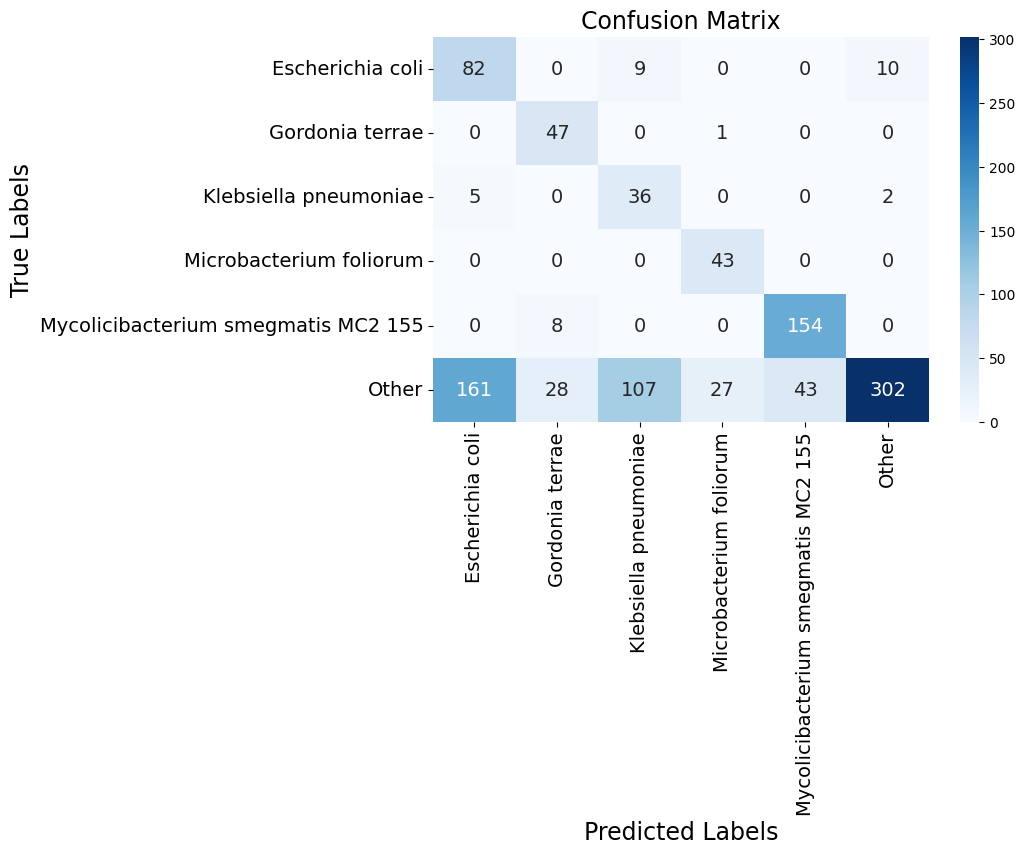

In [ ]:
# Protein only, single-headed, w/ Other
model_trainer.run_inference(upsampled=False, verbose=False)
model_trainer.confusion_matrix(figsize=(8,5))

predictions of last batch are:
binary probabilities:
tensor([[1.6772e-03],
        [3.2303e-01],
        [9.8282e-01],
        [5.2708e-05],
        [7.0273e-01],
        [7.1947e-01],
        [7.6230e-01],
        [4.1504e-02],
        [9.5819e-01]], device='cuda:0', grad_fn=<SigmoidBackward0>)
--------------------------------------------------
main class probs:
tensor([[1.0000e+00, 3.6915e-10, 1.4785e-10, 6.9190e-13, 5.4175e-15],
        [9.9985e-01, 6.2069e-07, 1.5208e-04, 1.8822e-07, 1.2678e-08],
        [2.1874e-24, 3.9610e-07, 2.0913e-26, 1.0000e+00, 5.0212e-24],
        [1.0000e+00, 6.8899e-12, 3.4580e-14, 3.1748e-16, 5.1729e-19],
        [3.5334e-12, 2.1400e-04, 8.7151e-06, 5.3204e-13, 9.9978e-01],
        [4.3658e-13, 2.0792e-04, 2.1500e-06, 1.7822e-13, 9.9979e-01],
        [8.1995e-15, 3.0147e-05, 1.2546e-06, 6.9670e-16, 9.9997e-01],
        [9.9953e-01, 3.1377e-04, 1.5207e-04, 2.7379e-06, 3.9504e-06],
        [8.8430e-22, 1.0000e+00, 9.4964e-18, 2.5656e-08, 1.8307e-09]],
   

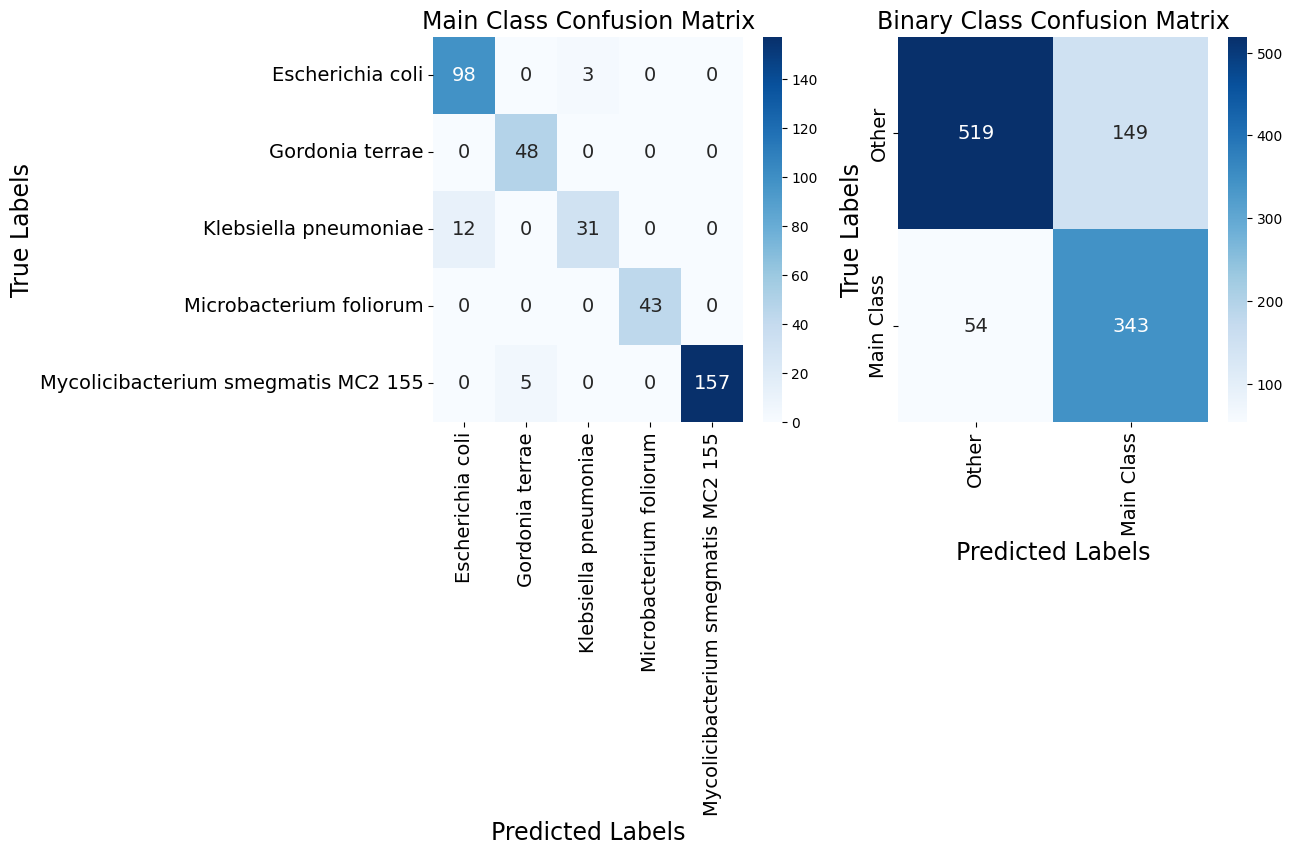

In [ ]:
# Protein only, double-headed, w/ Other
model_trainer.run_inference(upsampled=False, verbose=False)
model_trainer.confusion_matrix(figsize=(11,5))

### Summary Plots

In [ ]:
# Set up file paths
file_name = 'optimal_loss_accuracy_results_proteinonly'
loss_accuracy_file_path = file_path + 'data/optuna_results/' + file_name + '.pkl'

# Load previous data
with open(loss_accuracy_file_path, 'rb') as f:
    loss_accuracy_df = pickle.load(f)

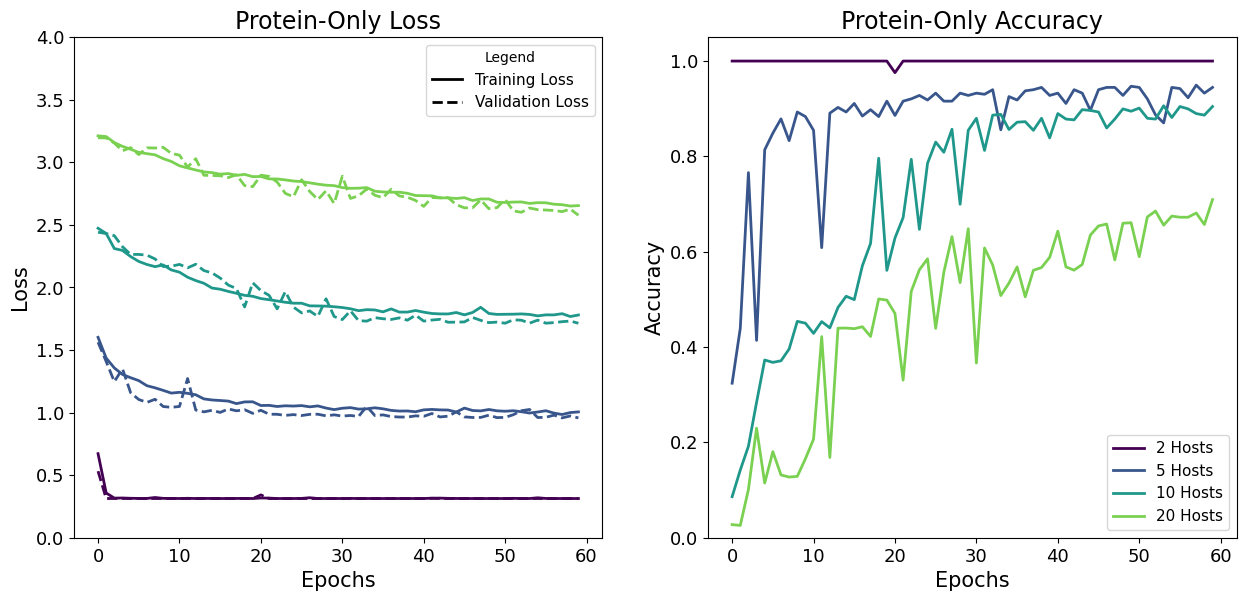

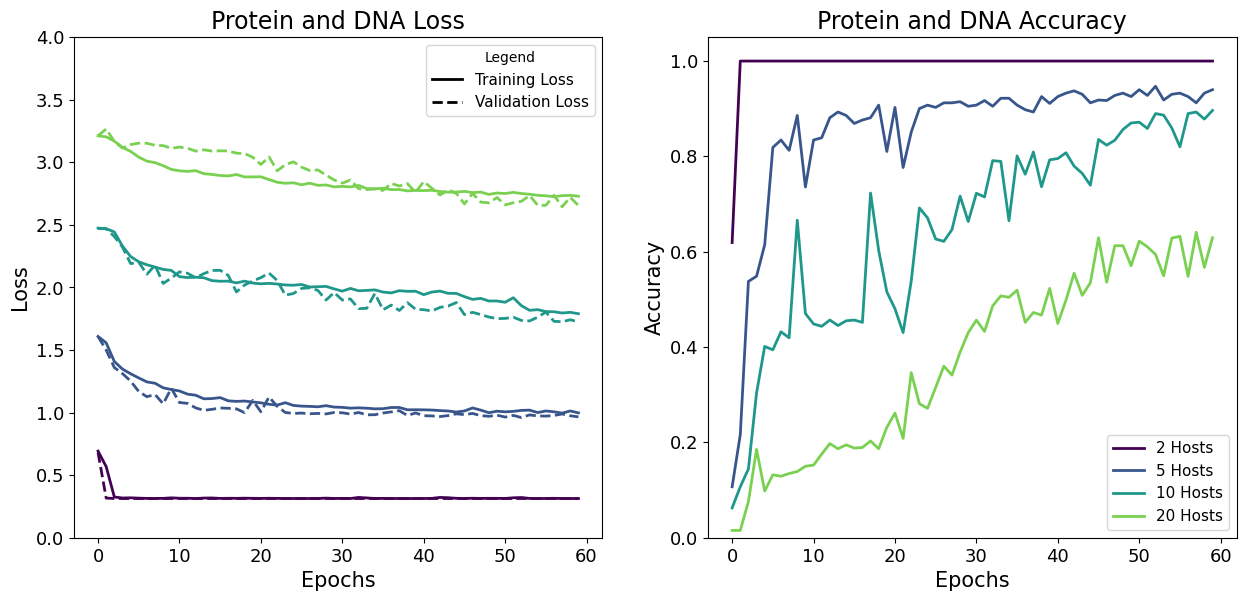

In [ ]:
model_type = 'protein_only'
single_or_double = 'single'
include_other = 'False'
normalize = False

plot_loss_and_accuracy(loss_accuracy_df, model_type=model_type, single_or_double=single_or_double, include_other=include_other, figsize=(15,6.5), normalize=normalize, title='Protein-Only')


model_type = 'protein_and_dna'
plot_loss_and_accuracy(loss_accuracy_df, model_type=model_type, single_or_double=single_or_double, include_other=include_other, figsize=(15,6.5), normalize=normalize, title='Protein and DNA')

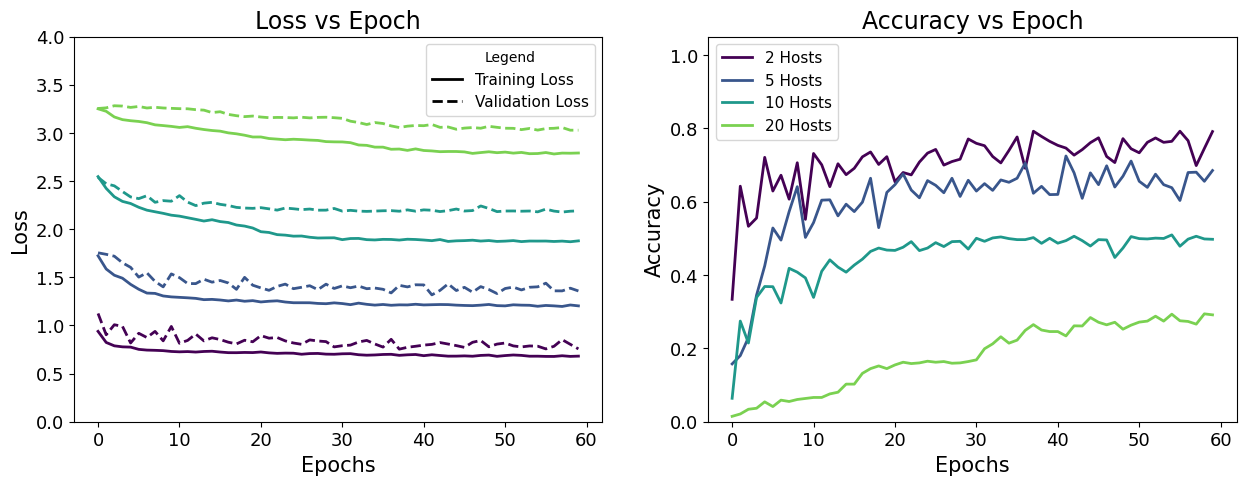

In [ ]:
model_type = 'protein_only'
single_or_double = 'single'
include_other = 'True'
normalize = False

plot_loss_and_accuracy(loss_accuracy_df, model_type=model_type, single_or_double=single_or_double, include_other=include_other, figsize=(15,5), normalize=normalize)

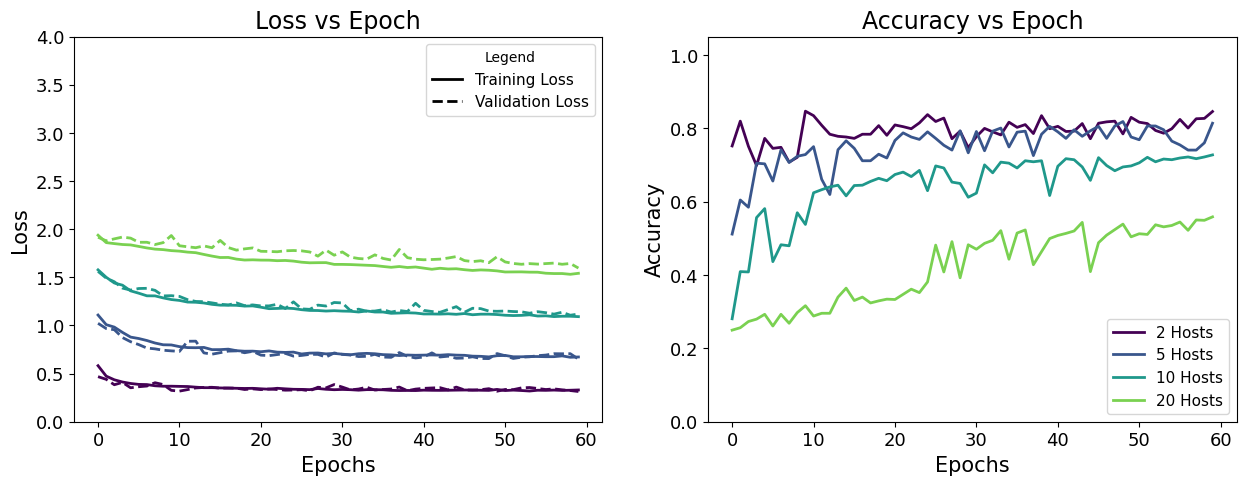

In [ ]:
model_type = 'protein_only'
single_or_double = 'double'
include_other = 'True'
normalize = False

plot_loss_and_accuracy(loss_accuracy_df, model_type=model_type, single_or_double=single_or_double, include_other=include_other, figsize=(15,5), normalize=normalize)

[1.0, 0.9447115384615384, 0.9046052631578947, 0.7093436454849499]
[0.7913602941176471, 0.6851511437908497, 0.49754901960784315, 0.29146241830065356]
[0.8460093896713615, 0.8140845070422535, 0.7276995305164319, 0.5586854460093896]


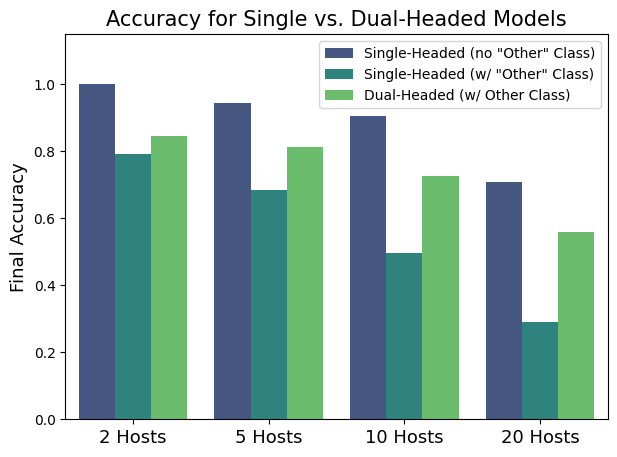

In [ ]:
plot_single_vs_dual_head(loss_accuracy_df, figsize=(7,5))

#### Model Summary

In [ ]:
from torchsummary import summary
summary(model_trainer.model, input_size=(16, 1280))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 16, 512]         655,872
              ReLU-2              [-1, 16, 512]               0
           Dropout-3              [-1, 16, 512]               0
            Linear-4              [-1, 16, 256]         131,328
              ReLU-5              [-1, 16, 256]               0
           Dropout-6              [-1, 16, 256]               0
            Linear-7              [-1, 16, 128]          32,896
              ReLU-8              [-1, 16, 128]               0
           Dropout-9              [-1, 16, 128]               0
           Linear-10               [-1, 16, 64]           8,256
             ReLU-11               [-1, 16, 64]               0
          Dropout-12               [-1, 16, 64]               0
           Linear-13                [-1, 16, 5]             325
          Softmax-14                [-1

# Optuna Optimization

## Set up functions

In [ ]:
def protein_only_optuna_objective(trial):

  file_path = "/content/drive/My Drive/DS_266_Final_Project_PBI"
  device = torch.device('cuda')
  model_size = '_650M'
  num_classes = 5
  ESM_model_size = "facebook/esm2_t33_650M_UR50D"
  epochs=2

  # Define the hyperparameters as trial suggestions
  learning_rate = trial.suggest_float('learning_rate', 1e-5, 3e-2, log=True)
  dropout_rate = trial.suggest_categorical('dropout_rate', [0.1, 0.3, 0.5])
  hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes', ['1024_512_256_64', '512_256_128_64', '512_256_128', '512_256', '256_128_64', '128_64_32'])
  protein_combination = trial.suggest_categorical('protein_combination', ['mean', 'max'])
  init_mode = trial.suggest_categorical('init_mode', ['kaiming_normal', 'kaiming_uniform', 'none'])
  batch_size = trial.suggest_categorical('batch_size', [8, 16, 32, 64])

  # Convert hidden_layers from string to a list of integers
  hidden_layers = list(map(int, hidden_layer_sizes.split('_')))


  # Create model with these parameters
  trainer = ProteinOnlyTrainingClass(file_path=file_path, device=device, num_classes=num_classes, protein_combo_style=protein_combination, hidden_layer_sizes=hidden_layers, ESM_model_size=ESM_model_size,
                keep_other=False, model_size=model_size, dropout=dropout_rate, init_mode=init_mode, batch_size=batch_size)

  loss_function = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(trainer.model.parameters(), lr=learning_rate)

  # Train the model
  train_losses, val_losses, val_accuracies = trainer.run_training(loss_function, optimizer, num_epochs=epochs)

  # Save results for additional analysis
  train_losses_total.append(train_losses)
  val_losses_total.append(val_losses)
  val_accuracies_total.append(val_accuracies)

  # Optimize for highest average validation accuracy
  return np.mean(val_accuracies)


## Run Optuna Experiment and Save Results

In [ ]:
# Set up variables to capture results
train_losses_total = []
val_losses_total = []
val_accuracies_total = []

# Setup objective function and run for n number of trials
study = optuna.create_study(direction='maximize')
study.optimize(protein_only_optuna_objective, n_trials=2, callbacks=[print_intermediate_values])

# Print the final results
print("Best hyperparameters: {}".format(study.best_params))
print("Best value (max validation accuracy): ", study.best_value)
print("Best hyperparameters: ", study.best_params)

plot_optimization_history(study)
plot_param_importances(study)

In [ ]:
plot_optuna_results(val_losses_total, val_accuracies_total, figsize=(15,5), exp_to_include='')

In [ ]:
file_name = 'optuna_results_test_ignore'
df, df_plots = save_optuna_results(study, train_losses_total, val_losses_total, val_accuracies_total, file_path, file_name)

## Load Optuna Results

In [ ]:
import pickle
# Set up file paths
file_name = 'optuna_results_5class_proteinonly'
optuna_study_file_path = file_path + 'data/optuna_results/' + file_name + '.csv'
loss_accuracy_file_path = file_path + 'data/optuna_results/' + file_name + '.pkl'

# Load data
optuna_df = pd.read_csv(optuna_study_file_path)
with open(loss_accuracy_file_path, 'rb') as f:
    loss_accuracy_df = pickle.load(f)


In [ ]:
optuna_df.sort_values(by='value', ascending=False)

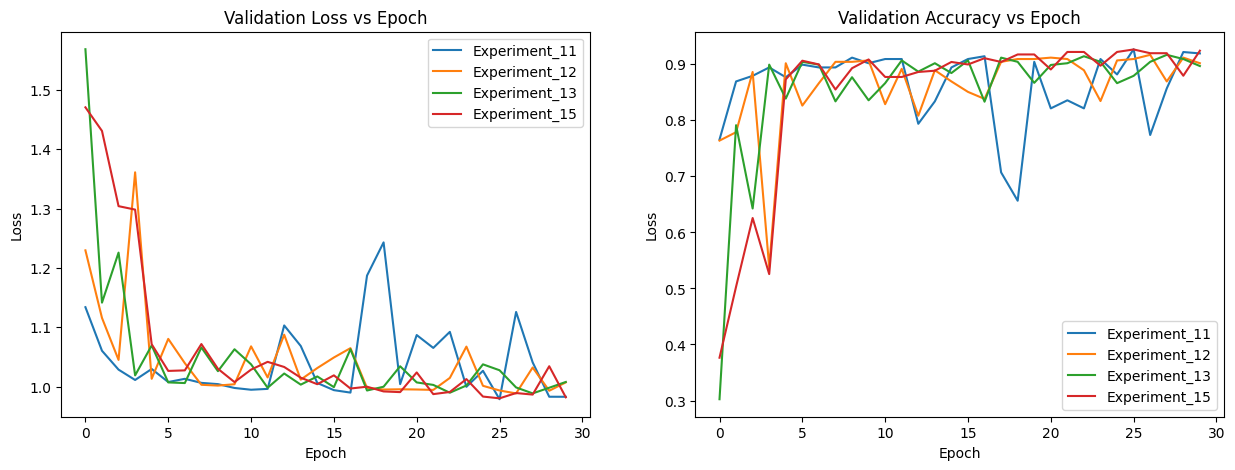

In [ ]:
plot_optuna_results(val_losses_total, val_accuracies_total, figsize=(15,5), exp_to_include=[12,11,13,15])